Here, we perform machine learning analysis to create an optimal model to predict the handedness of a galaxy.

First, we import the necessary modules and read in the data.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
plt.rcParams["figure.figsize"] = (20,10)

In [3]:
URL = 'http://vfacstaff.ltu.edu/lshamir/data/assym/p_all_full.csv'
df = pd.read_csv(URL)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13440 entries, 0 to 13439
Columns: 455 entries, rotation to ID
dtypes: float64(383), int64(71), object(1)
memory usage: 46.7+ MB


I decided to drop NaN entries instead of imputing values. We only lost 3.6% of our overall data.

In [5]:
df_dropped = df.replace(-9999.00, np.nan).dropna()
df_dropped.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12952 entries, 0 to 13439
Columns: 455 entries, rotation to ID
dtypes: float64(408), int64(46), object(1)
memory usage: 45.1+ MB


Now we can start the analysis. We will import some modules from scikit-learn and split our data into training and testing sets.

In [6]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc

In [7]:
X_train, X_test, y_train, y_test = train_test_split(df_dropped.drop('rotation', axis=1), df_dropped['rotation'], 
                                                    random_state=20, stratify=df_dropped['rotation'])

First, we'll try logistic regression with the default parameters. Our score is 0.519, which is not great.

In [8]:
model = LogisticRegression()
model.fit(X_train, y_train)
print('Training data score:', model.score(X_train, y_train))
print('Test data score:', model.score(X_test, y_test))

/home/rashmi/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Training data score: 0.518118179946469
Test data score: 0.5185299567634342


Let's tune the hyperparameter C using grid search cross validation. We arrive at the best value for C (0.0001).

In [9]:
cv_model = GridSearchCV(LogisticRegression(), param_grid={'C':[0.0001, 0.001, 0.01, 0.1, 1, 10, 100]}, cv=5)
cv_model.fit(X_train, y_train)
cv_model.best_params_

/home/rashmi/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rashmi/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rashmi/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rashmi/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rashmi/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs

{'C': 0.0001}

Unfortunately, the cross validated model gave us the same score as the default model.

In [10]:
print('Training data score:', cv_model.score(X_train, y_train))
print('Test data score:', cv_model.score(X_test, y_test))

Training data score: 0.518118179946469
Test data score: 0.5185299567634342


We can plot the ROC curve. The AUC is 0.50, which is equivalent to a coin toss, so not great.

In [11]:
cv_probs = cv_model.predict_proba(X_test)
cv_probs = cv_probs[:, 1]
no_skill = np.zeros(len(y_test))

In [12]:
tpr, fpr, thresh = roc_curve(y_test, cv_probs, pos_label='cw')
ns_tpr, ns_fpr, ns_thresh = roc_curve(y_test, no_skill, pos_label='cw')

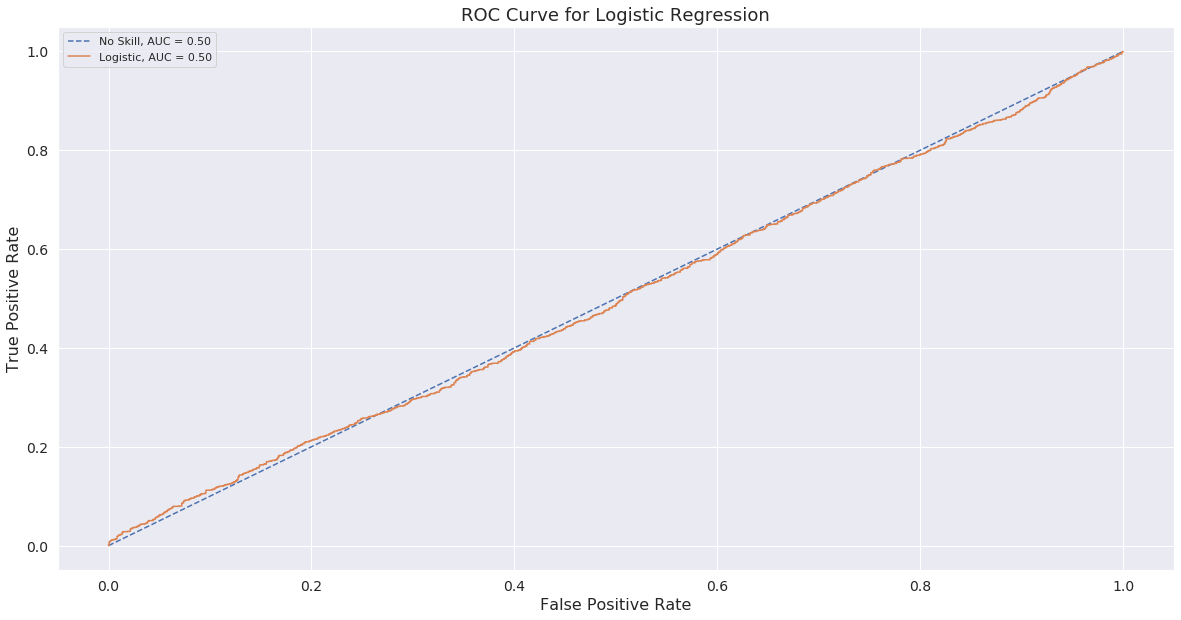

In [13]:
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill, AUC = %.2f' % auc(ns_fpr, ns_tpr))
plt.plot(fpr, tpr, marker='.', markersize=0.1, label='Logistic, AUC = %.2f' % auc(fpr, tpr))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC Curve for Logistic Regression', fontsize=18)
plt.legend()
plt.show()

My next model is a support vector machine. First, we will need to scale our features.

In [14]:
from sklearn.preprocessing import StandardScaler

X_scaled = StandardScaler().fit_transform(df_dropped.drop('rotation', axis=1))
X_train_scaled, X_test_scaled, y_train, y_test = train_test_split(X_scaled, df_dropped['rotation'], 
                                                                  random_state=20, stratify=df_dropped['rotation'])

/home/rashmi/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/rashmi/anaconda3/lib/python3.7/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


Our score (0.523) is a little better!

In [15]:
from sklearn.svm import LinearSVC

svm_model = LinearSVC(random_state=20).fit(X_train_scaled, y_train)
print('Training data score:', svm_model.score(X_train_scaled, y_train))
print('Test data score:', svm_model.score(X_test_scaled, y_test))

Training data score: 0.5588840848260243
Test data score: 0.5234712785670167


/home/rashmi/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Plotting the ROC curve. Our AUC this time is 0.52. We are making some progress.

In [16]:
svm_probs = svm_model.decision_function(X_test_scaled)
no_skill = np.zeros(len(y_test))

In [17]:
tpr, fpr, thresh = roc_curve(y_test, svm_probs, pos_label='ccw')
ns_tpr, ns_fpr, ns_thresh = roc_curve(y_test, no_skill, pos_label='ccw')

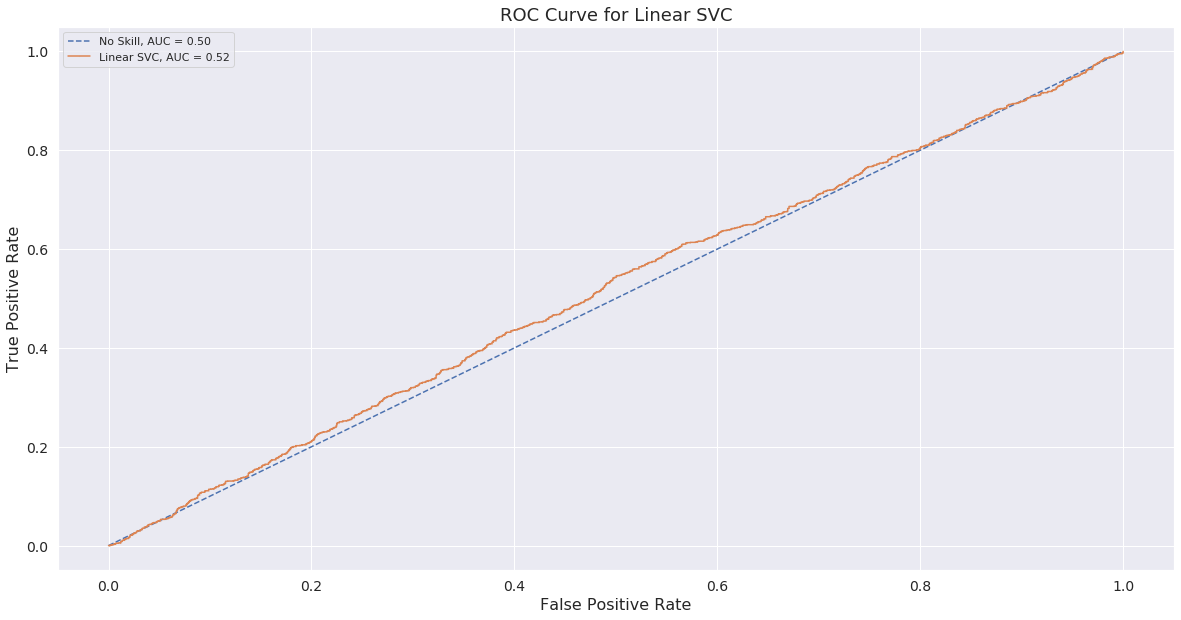

In [18]:
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill, AUC = %.2f' % auc(ns_fpr, ns_tpr))
plt.plot(fpr, tpr, marker='.', markersize=0.1, label='Linear SVC, AUC = %.2f' % auc(fpr, tpr))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC Curve for Linear SVC', fontsize=18)
plt.legend()
plt.show()

We can attempt to reduce the dimensionality using PCA. Then we can use a support vector machine on the reduced data to see if we can make an improvement. Based on the score below, it seems we don't see any improvement at all.

In [19]:
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline

pca = PCA(n_components=100, random_state=20)
svm_reduced = LinearSVC(random_state=20)

pipeline = make_pipeline(pca, svm_reduced)
pipeline.fit(X_train_scaled, y_train)
print('Training data score:', pipeline.score(X_train_scaled, y_train))
print('Test data score:', pipeline.score(X_test_scaled, y_test))

/home/rashmi/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Training data score: 0.528000823553634
Test data score: 0.5154416306361952


Next we will try out a random forest classifier. This gave a score of 0.577, which is a bit better, but our training data score is 0.988. This is strong evidence that our model overfit the data.

In [20]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

random_forest = RandomForestClassifier(random_state=20)
random_forest.fit(X_train, y_train)
print('Training data score:', random_forest.score(X_train, y_train))
print('Test data score:', random_forest.score(X_test, y_test))

/home/rashmi/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Training data score: 0.9882643607164917
Test data score: 0.577208153180976


Plotting the ROC curve we see that we have made some progress. The AUC has improved, with a value of 0.61.

In [21]:
rf_probs = random_forest.predict_proba(X_test)
rf_probs = rf_probs[:, 1]
no_skill = np.zeros(len(y_test))

In [22]:
tpr, fpr, thresh = roc_curve(y_test, rf_probs, pos_label='ccw')
ns_tpr, ns_fpr, ns_thresh = roc_curve(y_test, no_skill, pos_label='ccw')

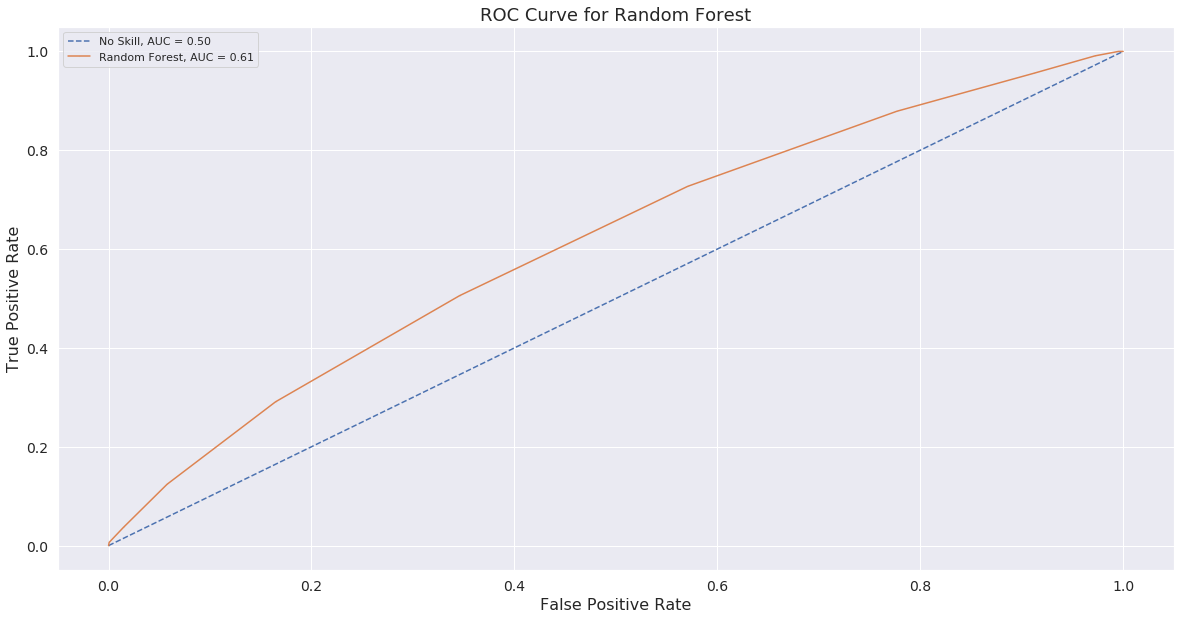

In [23]:
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill, AUC = %.2f' % auc(ns_fpr, ns_tpr))
plt.plot(fpr, tpr, marker='.', markersize=0.1, label='Random Forest, AUC = %.2f' % auc(fpr, tpr))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC Curve for Random Forest', fontsize=18)
plt.legend()
plt.show()

Finally, we will try a gradient boosting model. We see a lot of improvement, with a score of 0.659!

In [24]:
gb_model = GradientBoostingClassifier(random_state=20)
gb_model.fit(X_train, y_train)
print('Training data score:', gb_model.score(X_train, y_train))
print('Test data score:', gb_model.score(X_test, y_test))

Training data score: 0.7260654725138974
Test data score: 0.6587399629400865


Our ROC curve shows a significant improvement, with an AUC of 0.72.

In [25]:
gb_probs = gb_model.predict_proba(X_test)
gb_probs = gb_probs[:, 1]
no_skill = np.zeros(len(y_test))

In [26]:
tpr, fpr, thresh = roc_curve(y_test, gb_probs, pos_label='ccw')
ns_tpr, ns_fpr, ns_thresh = roc_curve(y_test, no_skill, pos_label='ccw')

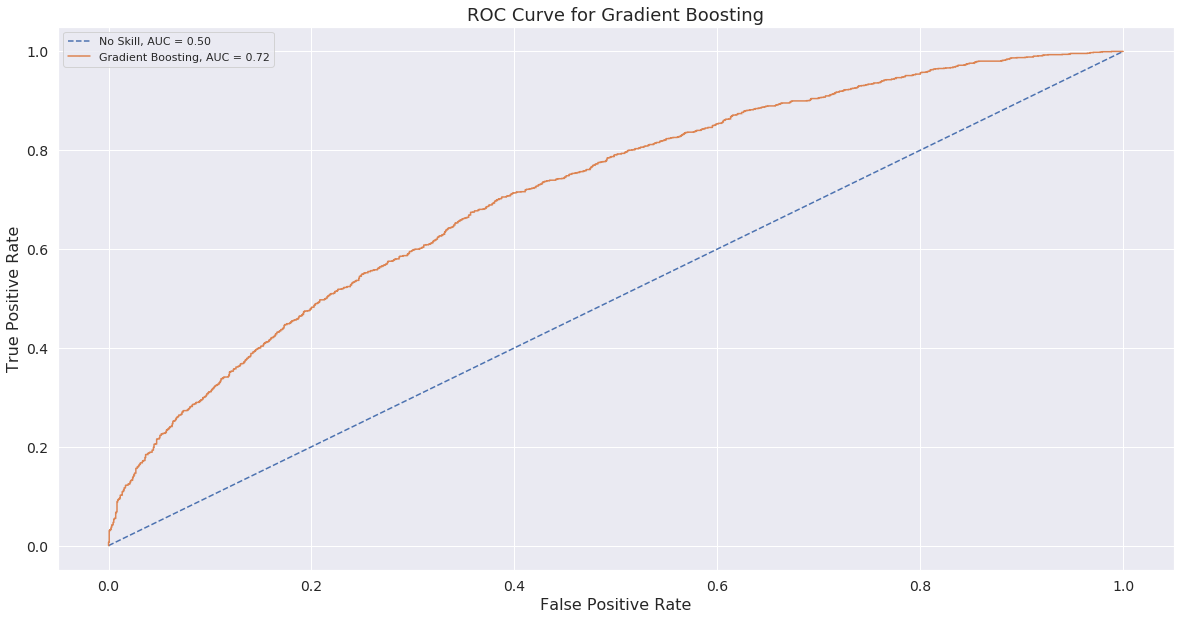

In [27]:
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill, AUC = %.2f' % auc(ns_fpr, ns_tpr))
plt.plot(fpr, tpr, marker='.', markersize=0.1, label='Gradient Boosting, AUC = %.2f' % auc(fpr, tpr))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC Curve for Gradient Boosting', fontsize=18)
plt.legend()
plt.show()

I decided to stop here because the paper that this project is related to achieved a score of 64%, which is roughly 2% lower than my score.

Finally, I plot the most significant features and the confusion matrix.

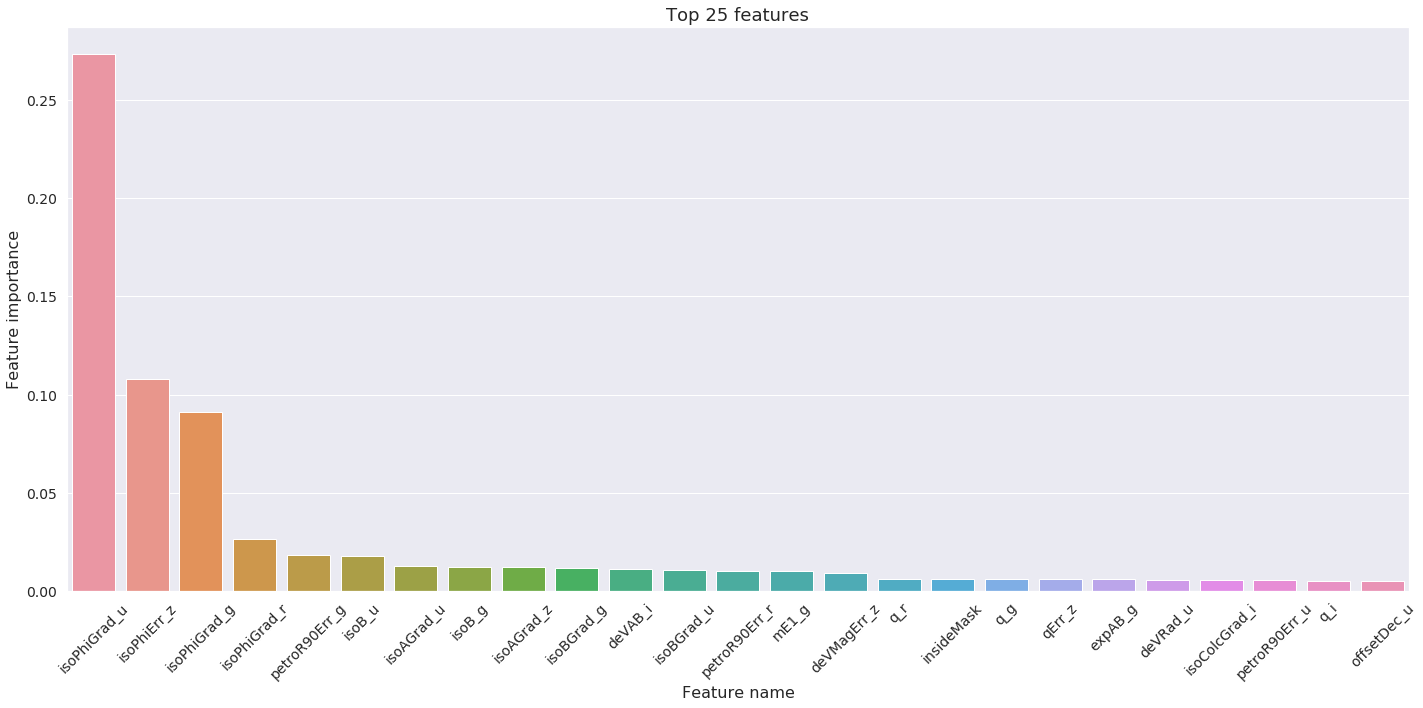

In [28]:
feature_ranks = np.flip(np.argsort(gb_model.feature_importances_))
top25_features = []
for i in feature_ranks[:25]:
    top25_features.append(df.columns[i])

sns.barplot(x=top25_features, y=np.flip(np.sort(gb_model.feature_importances_))[:25])
plt.xticks(rotation=45, fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Feature name', fontsize=16)
plt.ylabel('Feature importance', fontsize=16)
plt.title('Top 25 features', fontsize=18)
plt.tight_layout()
plt.show()

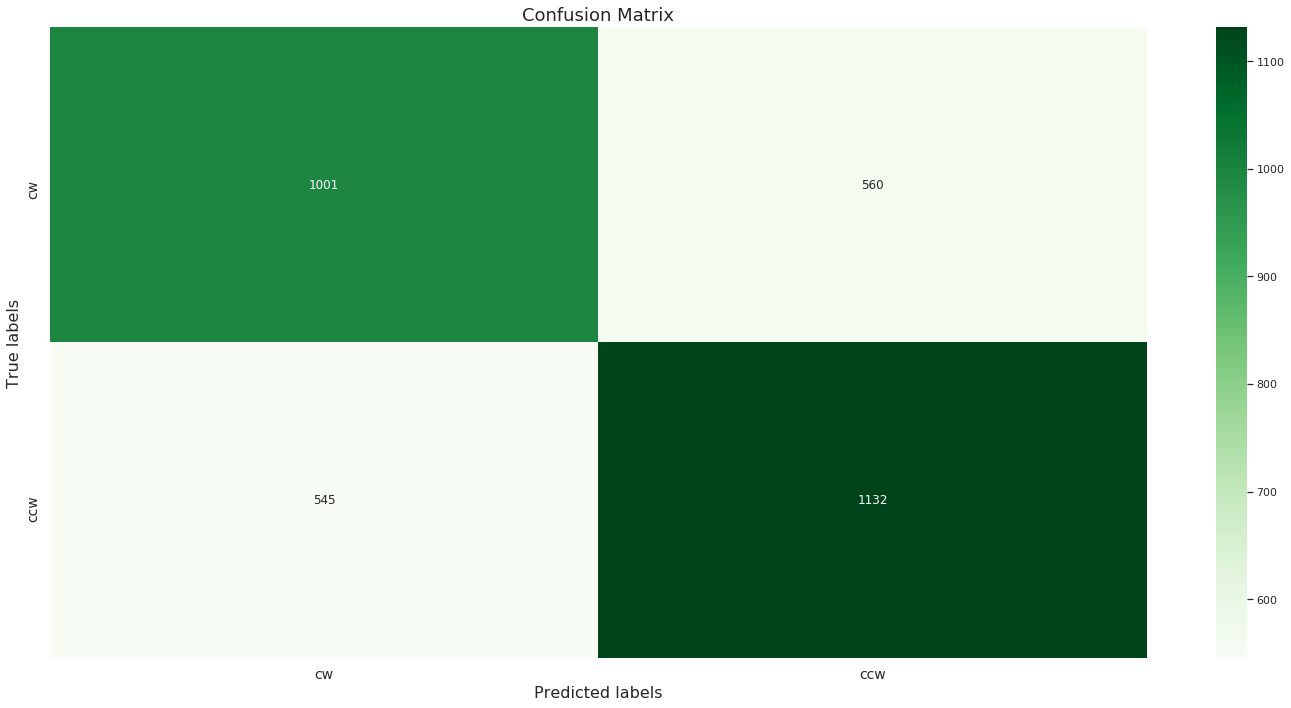

In [29]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, gb_model.predict(X_test))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens')
plt.xticks(ticks=[0.5, 1.5], labels=['cw', 'ccw'], fontsize=14)
plt.yticks(ticks=[0.5, 1.5], labels=['cw', 'ccw'], fontsize=14)
plt.xlabel('Predicted labels', fontsize=16)
plt.ylabel('True labels', fontsize=16)
plt.title('Confusion Matrix', fontsize=18)
plt.tight_layout()
plt.show()